In [34]:
!pip install torchviz

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
from IPython.display import Image
import os
import matplotlib.pyplot as plt

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 3 Convolutional Layers with padding to maintain image dimensions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 filters

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # CIFAR-10 image is 32x32, after pooling it reduces to 4x4
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10 has 10 classes

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Apply convolutions + ReLU activations + Pooling
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> Pool1
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> Pool2
        x = self.pool(torch.relu(self.conv3(x)))  # Conv3 -> Pool3

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 4 * 4)  # Flatten the output to fit into the fully connected layers

        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Output layer for classification (10 classes)

        return x  # Ensure the model returns the output

In [36]:
# Set the batch size
batch_size = 64

# Define the data transformation (augmentation + normalization)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

# Download the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [37]:
# Split the training data into train and validation sets
train_len = int(0.9 * len(trainset))  # 90% for training
val_len = len(trainset) - train_len   # 10% for validation
train_data, val_data = random_split(trainset, [train_len, val_len])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check the data loaders
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 704
Number of validation batches: 79
Number of test batches: 157


In [38]:
# Initialize the model
model = SimpleCNN()

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Initialize accuracy tracking lists
val_accuracies = []
test_accuracies = []

num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs} - Train Accuracy: {train_acc:.2f}%")

    # Validation accuracy
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)
    print(f"           Validation Accuracy: {val_acc:.2f}%")

    # Test accuracy
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)
    print(f"           Test Accuracy: {test_acc:.2f}%")

Epoch 1/35 - Train Accuracy: 44.31%
           Validation Accuracy: 52.74%
           Test Accuracy: 53.88%
Epoch 2/35 - Train Accuracy: 60.22%
           Validation Accuracy: 60.30%
           Test Accuracy: 61.81%
Epoch 3/35 - Train Accuracy: 66.54%
           Validation Accuracy: 66.18%
           Test Accuracy: 66.40%
Epoch 4/35 - Train Accuracy: 70.16%
           Validation Accuracy: 69.26%
           Test Accuracy: 68.84%
Epoch 5/35 - Train Accuracy: 72.34%
           Validation Accuracy: 70.58%
           Test Accuracy: 71.00%
Epoch 6/35 - Train Accuracy: 74.44%
           Validation Accuracy: 73.60%
           Test Accuracy: 73.47%
Epoch 7/35 - Train Accuracy: 75.95%
           Validation Accuracy: 74.12%
           Test Accuracy: 74.94%
Epoch 8/35 - Train Accuracy: 76.92%
           Validation Accuracy: 73.06%
           Test Accuracy: 73.92%
Epoch 9/35 - Train Accuracy: 77.98%
           Validation Accuracy: 75.96%
           Test Accuracy: 75.77%
Epoch 10/35 - Train Accuracy

In [40]:
# Evaluate on test data after training
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6384, Test Accuracy: 79.47%


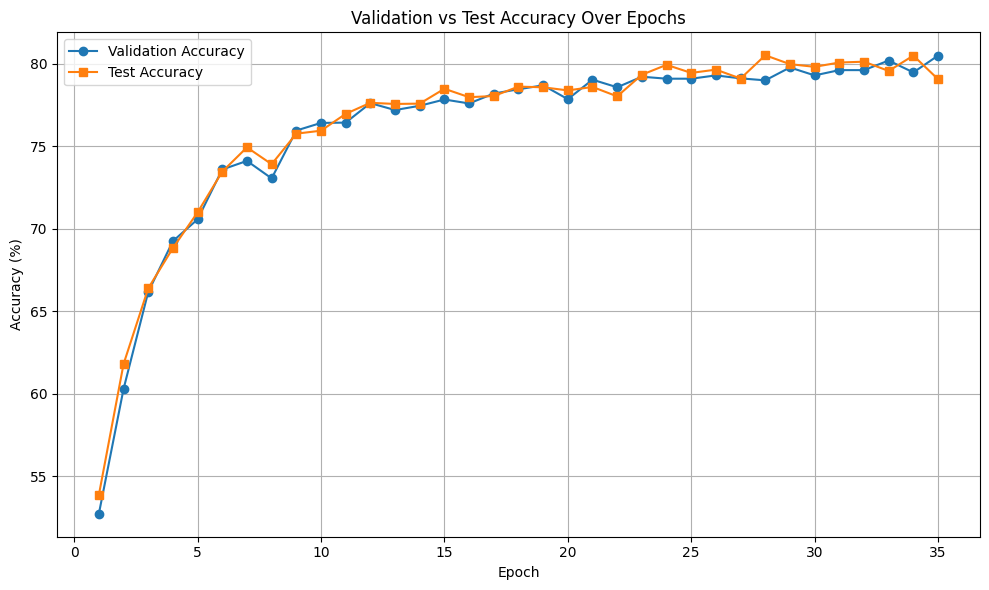

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation vs Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from torchsummary import summary
from torchviz import make_dot

# Display model layer summary
summary(model, input_size=(3, 32, 32))

# Create a dummy input and generate the architecture graph
dummy_input = torch.randn(1, 3, 32, 32).to(device)
output = model(dummy_input)

# Visualize the model architecture
make_dot(output, params=dict(list(model.named_parameters()))).render("model_architecture", format="png", cleanup=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 512]       1,049,088
            Linear-8                   [-1, 10]           5,130
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.38
Estimated Total Size (MB): 4.94
----------------------------------------------------------------


'model_architecture.png'

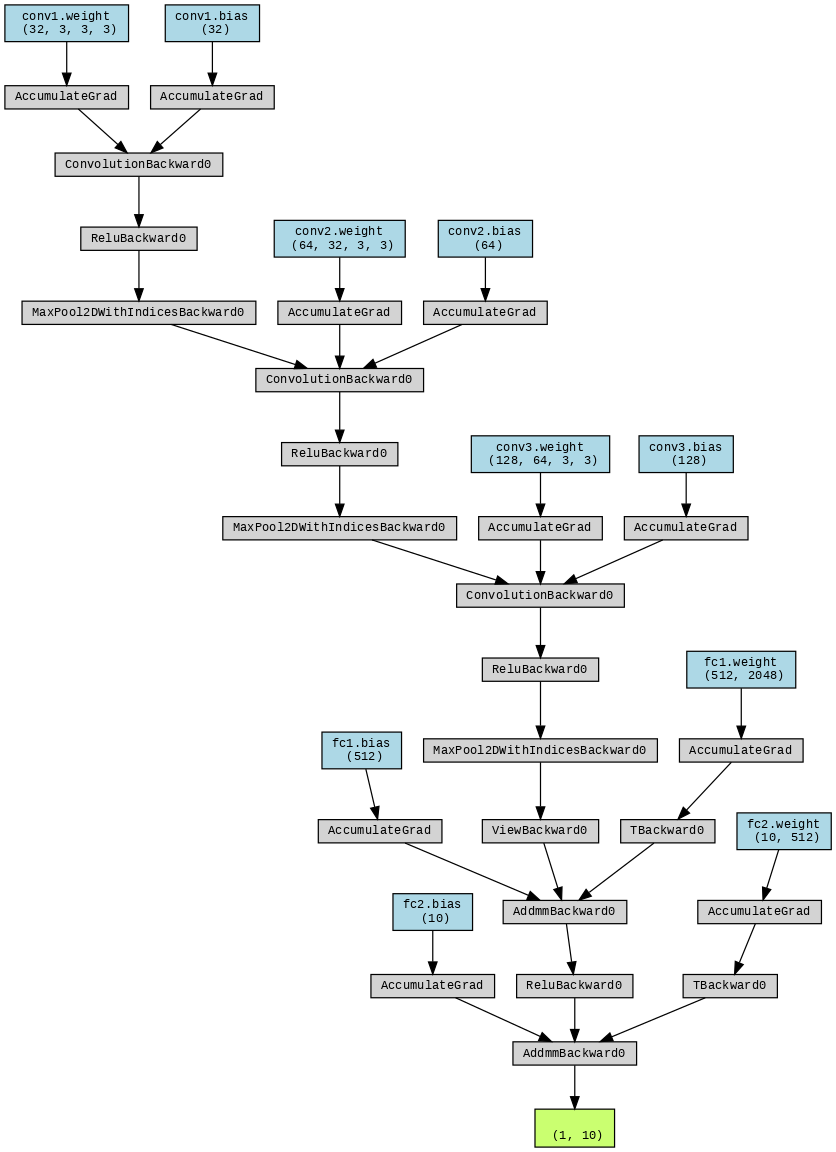

In [11]:
#Import required libraries
from torchviz import make_dot
from IPython.display import Image

#Generate a dummy input and pass through model
dummy_input = torch.randn(1, 3, 32, 32).to(device)
output = model(dummy_input)

#Create and render the model architecture diagram
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png", cleanup=True)

# Step 5: Display the rendered image inline
Image("model_architecture.png")

<Figure size 1000x800 with 0 Axes>

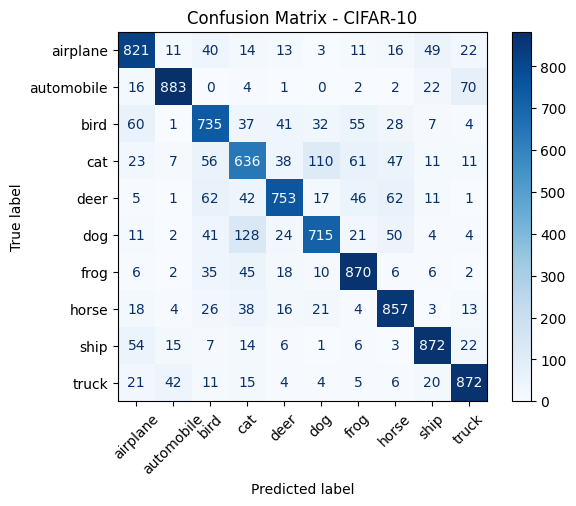

In [43]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Put model in evaluation mode
model.eval()

# Gather all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - CIFAR-10")
plt.grid(False)
plt.show()